In [1]:
from graphchem.datasets import load_cn
from sklearn.model_selection import train_test_split

smiles, targets = load_cn()
smiles_train, smiles_test, targets_train, targets_test = train_test_split(smiles, targets, random_state=24)

In [2]:
from graphchem import CompoundOperator

co = CompoundOperator()
train_loss, valid_loss = co.train(
    smiles_train, targets_train, verbose=5,
    valid_size=0.35,
    valid_patience=64,
    batch_size=32,
    epochs=750,
    random_state=25,
    lr=0.001,
    lr_decay=0.0
)

Epoch: 0 | Train Loss: 1450.6783098493304 | Valid Loss: 750.0137329101562
Epoch: 5 | Train Loss: 427.6949026925223 | Valid Loss: 426.94683837890625
Epoch: 10 | Train Loss: 343.3581760951451 | Valid Loss: 370.42926025390625
Epoch: 15 | Train Loss: 262.30320739746094 | Valid Loss: 268.6890563964844
Epoch: 20 | Train Loss: 241.9115469796317 | Valid Loss: 241.2530059814453
Epoch: 25 | Train Loss: 239.87794712611608 | Valid Loss: 228.93991088867188
Epoch: 30 | Train Loss: 216.08201599121094 | Valid Loss: 219.17990112304688
Epoch: 35 | Train Loss: 212.84924098423548 | Valid Loss: 220.8962860107422
Epoch: 40 | Train Loss: 197.97086007254464 | Valid Loss: 206.03759765625
Epoch: 45 | Train Loss: 208.4076167515346 | Valid Loss: 230.1829376220703
Epoch: 50 | Train Loss: 196.65850285121374 | Valid Loss: 207.84384155273438
Epoch: 55 | Train Loss: 183.40745980398995 | Valid Loss: 205.69155883789062
Epoch: 60 | Train Loss: 191.83479963030135 | Valid Loss: 216.6591033935547
Epoch: 65 | Train Loss: 200

In [3]:
from sklearn.metrics import mean_absolute_error, r2_score

pred_train = co.use(smiles_train)
pred_test = co.use(smiles_test)
print('MAE Train: {}'.format(
    mean_absolute_error(pred_train, targets_train)
))
print('MAE Test: {}'.format(
    mean_absolute_error(pred_test, targets_test)
))
print('R2 Train: {}'.format(
    r2_score(pred_train, targets_train)
))
print('R2 Test: {}'.format(
    r2_score(pred_test, targets_test)
))


MAE Train: 7.8213185651924295
MAE Test: 10.947252009640568
R2 Train: 0.812224944405808
R2 Test: 0.6987691708865782


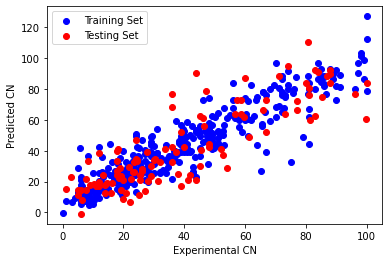

In [4]:
from matplotlib import pyplot as plt

plt.clf()
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.scatter(targets_train, pred_train, color='blue', label='Training Set')
plt.scatter(targets_test, pred_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()

In [5]:
co.save_model('model.pt', 'encoder.enc')

In [6]:
co2 = CompoundOperator()
co2.load_model('model.pt', 'encoder.enc')
pred_train = co2.use(smiles_train)
pred_test = co2.use(smiles_test)
print('MAE Train: {}'.format(
    mean_absolute_error(pred_train, targets_train)
))
print('MAE Test: {}'.format(
    mean_absolute_error(pred_test, targets_test)
))
print('R2 Train: {}'.format(
    r2_score(pred_train, targets_train)
))
print('R2 Test: {}'.format(
    r2_score(pred_test, targets_test)
))

MAE Train: 7.8213185651924295
MAE Test: 10.947252009640568
R2 Train: 0.812224944405808
R2 Test: 0.6987691708865782


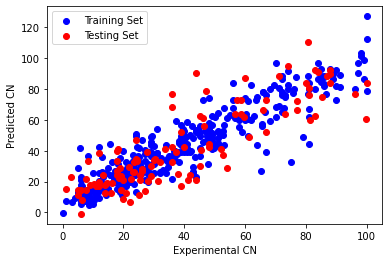

In [7]:
plt.clf()
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.scatter(targets_train, pred_train, color='blue', label='Training Set')
plt.scatter(targets_test, pred_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()